In [30]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

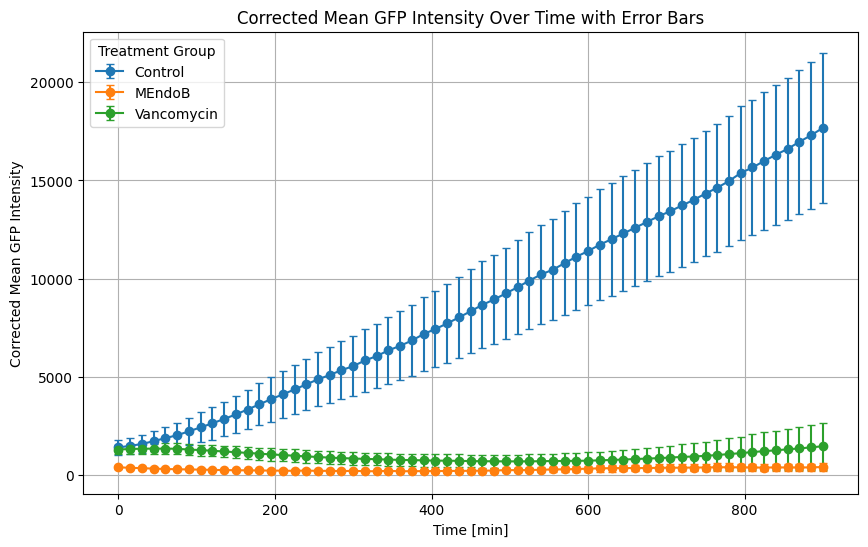

In [31]:
# Load the CSV file
file_path = "./gfp_intensity_results.csv"
df = pd.read_csv(file_path)

# --- Data Preprocessing ---
# Extract group and treatment information
df['Group'] = df['Identifier'].str.extract(r'([A-D])')[0]
df['Treatment'] = df['Group'].map({'A': 'MEndoB', 'B': 'Vancomycin', 'C': 'Control', 'D': 'Blank'})
df['Time'] = (df['Identifier'].str.extract(r'_(\d+)$').astype(int)-1) * 15

# Calculate the mean intensity of the blank wells (D4-D6) for each time point
blank_summary = (
    df[df['Treatment'] == 'Blank']
    .groupby('Time')
    .agg(
        Blank_Mean_GFP_Intensity=('Mean_GFP_Intensity', 'mean'),
        Blank_Mean_Total_Intensity=('Total_GFP_Intensity', 'mean')
    )
    .reset_index()
)

# Merge the blank summary with the original data for noise correction
df = pd.merge(df, blank_summary, on='Time', how='left')

# Apply noise correction
df['Corrected_Mean_GFP_Intensity'] = df['Mean_GFP_Intensity'] - df['Blank_Mean_GFP_Intensity']
df['Corrected_Total_GFP_Intensity'] = df['Total_GFP_Intensity'] - df['Blank_Mean_Total_Intensity']

# Filter out the blank wells for further analysis
df = df[df['Treatment'] != 'Blank']

# Group by Treatment and Time to calculate mean and standard error for the line plot
summary_mean = df.groupby(['Treatment', 'Time']).agg(
    Mean_Intensity=('Corrected_Mean_GFP_Intensity', 'mean'),
    SEM_Intensity=('Corrected_Mean_GFP_Intensity', 'sem')
).reset_index()

# Group by Treatment and Time for the area plot using total GFP intensity
summary_total = df.groupby(['Treatment', 'Time']).agg(
    Mean_Total_Intensity=('Corrected_Total_GFP_Intensity', 'mean')
).reset_index()

# --- Line Plot with Error Bars ---
plt.figure(figsize=(10, 6))
for treatment in summary_mean['Treatment'].unique():
    subset = summary_mean[summary_mean['Treatment'] == treatment]
    plt.errorbar(
        subset['Time'], subset['Mean_Intensity'], yerr=subset['SEM_Intensity'],
        label=treatment, capsize=3, marker='o', linestyle='-'
    )

plt.xlabel("Time [min]")
plt.ylabel("Corrected Mean GFP Intensity")
plt.title("Corrected Mean GFP Intensity Over Time with Error Bars")
plt.legend(title="Treatment Group")
plt.grid()
plt.show()

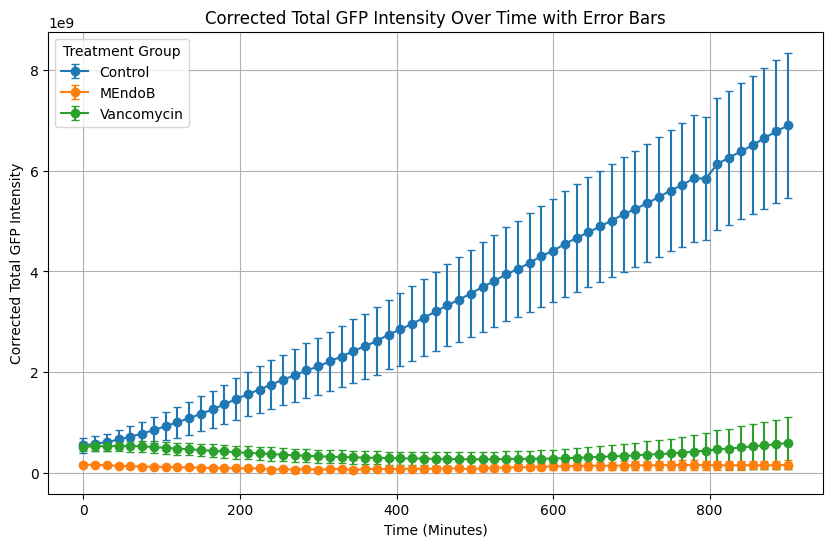

In [36]:
# Group by Treatment and Elapsed Time for the line plot using corrected total GFP intensity
summary_total_line = df.groupby(['Treatment', 'Time']).agg(
    Mean_Total_Intensity=('Corrected_Total_GFP_Intensity', 'mean'),
    SEM_Total_Intensity=('Corrected_Total_GFP_Intensity', 'sem')
).reset_index()

# --- Line Plot with Error Bars Using Corrected Total GFP Intensity ---
plt.figure(figsize=(10, 6))
for treatment in summary_total_line['Treatment'].unique():
    subset = summary_total_line[summary_total_line['Treatment'] == treatment]
    plt.errorbar(
        subset['Time'], subset['Mean_Total_Intensity'], yerr=subset['SEM_Total_Intensity'],
        label=treatment, capsize=3, marker='o', linestyle='-'
    )

# Adding labels and legend
plt.xlabel("Time (Minutes)")
plt.ylabel("Corrected Total GFP Intensity")
plt.title("Corrected Total GFP Intensity Over Time with Error Bars")
plt.legend(title="Treatment Group")
plt.grid()
plt.show()

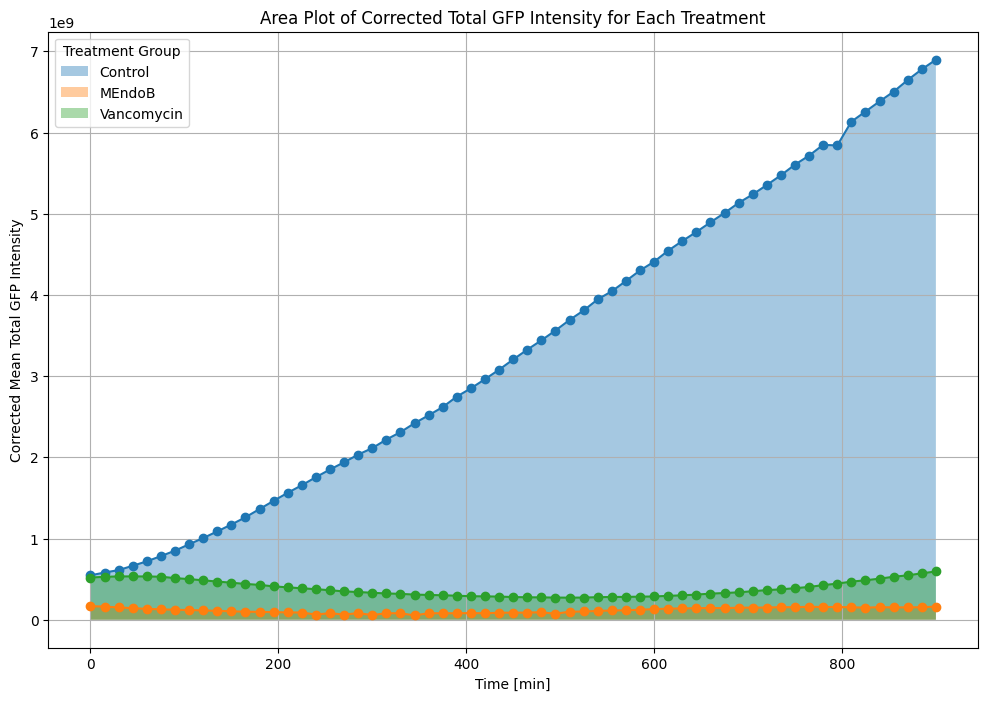

In [32]:
# --- Area Plot Using Total GFP Intensity ---
plt.figure(figsize=(12, 8))
for treatment in summary_total['Treatment'].unique():
    subset = summary_total[summary_total['Treatment'] == treatment]
    plt.fill_between(subset['Time'], subset['Mean_Total_Intensity'], alpha=0.4, label=treatment)
    plt.plot(subset['Time'], subset['Mean_Total_Intensity'], marker='o', linestyle='-')

plt.xlabel("Time [min]")
plt.ylabel("Corrected Mean Total GFP Intensity")
plt.title("Area Plot of Corrected Total GFP Intensity for Each Treatment")
plt.legend(title="Treatment Group")
plt.grid()
plt.show()

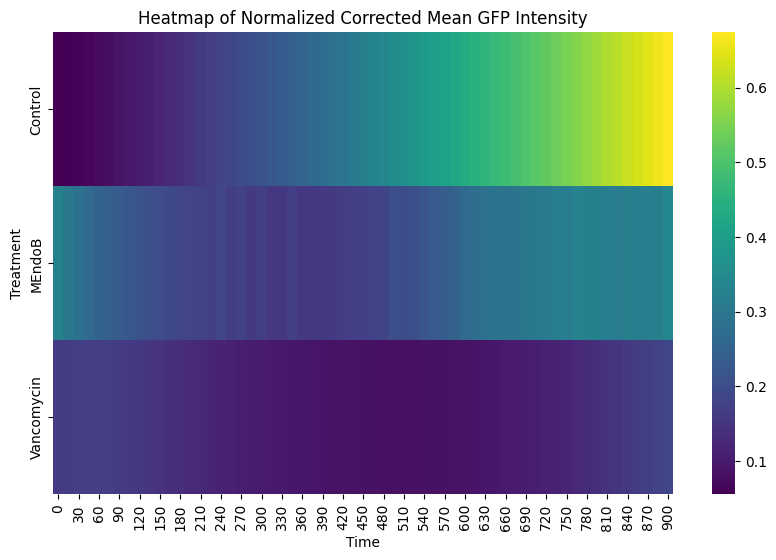

In [34]:
# Create Heatmap plot of Corrected Mean GFP Intensity with normalized values
# Create Heatmap plot of Corrected Mean GFP Intensity with normalized values
df['Normalized_Corrected_Mean_GFP_Intensity'] = df.groupby('Treatment')['Corrected_Mean_GFP_Intensity'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
heatmap_data = df.pivot_table(index='Treatment', columns='Time', values='Normalized_Corrected_Mean_GFP_Intensity', aggfunc='mean')
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=False, cmap='viridis', fmt='.2f')
plt.title("Heatmap of Normalized Corrected Mean GFP Intensity")
plt.show()


C:\Users\Kai\AppData\Local\Temp\ipykernel_44096\3983875290.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


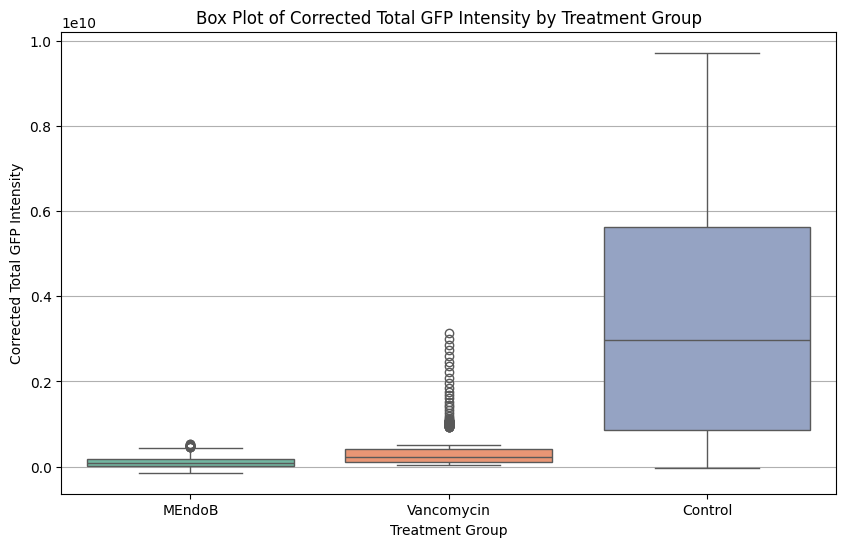

In [37]:
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df, x='Treatment', y='Corrected_Total_GFP_Intensity',
    palette='Set2', showfliers=True
)

# Adding labels and title
plt.xlabel("Treatment Group")
plt.ylabel("Corrected Total GFP Intensity")
plt.title("Box Plot of Corrected Total GFP Intensity by Treatment Group")
plt.grid(axis='y')
plt.show()